<a href="https://colab.research.google.com/github/ele9996/Heart-failure-clinical-records-analysis/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Heart failure data analysis

The goal of the project is to try to predict if a patient with heart failure is likely to survive or not and if there are some driving factors that may lead to heart failure.


##Import useful libraries


In [102]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from numpy import mean

np.random.seed(123)

##Dataset visualization and data exploration


In the following code snippet a visualization of the data is provided

In [103]:
#Dataset import and graphical visualization
df = pd.read_csv('https://raw.githubusercontent.com/ele9996/Heart-failure-clinical-records-analysis/master/heart_failure_clinical_records_dataset.csv')
df


,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,62.0,0,61,1,38,1,155000.00,1.1,143,1,1,270,0
295,55.0,0,1820,0,38,0,270000.00,1.2,139,0,0,271,0
296,45.0,0,2060,1,60,0,742000.00,0.8,138,0,0,278,0
297,45.0,0,2413,0,38,0,140000.00,1.4,140,1,1,280,0


I check the correlation between attributes in order to try to eliminate one of the two having high correlation between each other

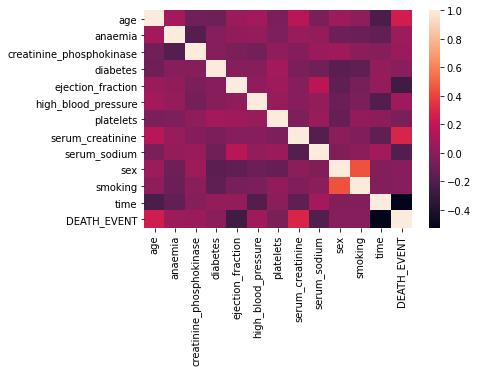

In [104]:
#I calculate correlation and print the correlation matrix
corr = df.corr()
sns.heatmap(corr)
#I notice that that there are no attibutes that are highly correlated one with another so selecting features by imposing a threshold on the correlation seems not to be a good idea
#valuta box plot and the distribution plot for the feature (both before and after the pca)

##Dimesionality Reduction: PCA

Since the dimensionality of the data is quite high and this can decrease the performances in terms of execution time I try to use PCA in order to reduce the number of features.

PCA is affected by scale so features in the data should be standardized in order to assure the best performances.

Standardization means scale the features into unit scale (mean=0, variance=1)


In [105]:
features = ['age','anaemia','creatinine_phosphokinase','diabetes','ejection_fraction','high_blood_pressure','platelets','serum_creatinine','serum_sodium','sex','smoking','time']

#Taking the features and placing in an array
x = df.loc[:, features].values


#Separating the target
y = df.loc[:,['DEATH_EVENT']].values#

# Standardizing the features
x = StandardScaler().fit_transform(x)


,1,2,3,4,5,6,7,8,9,DEATH_EVENT
0,0.877055,2.287104,1.033230,1.478227,-0.260820,-0.981816,-0.941060,0.556276,-0.932200,1
1,1.863753,-1.552894,0.719821,4.005022,4.273811,-2.832425,2.867899,-0.549446,0.142364,1
2,2.526429,1.369821,1.285596,-0.066119,-0.615287,-0.383891,-0.388868,-0.010873,-0.462690,1
3,0.579566,1.143232,0.631174,-0.920275,-0.374237,-1.221908,1.505988,0.978413,0.258351,1
4,-0.960485,2.639384,4.430958,0.292052,-0.927699,1.024387,0.790721,0.438838,-0.573906,1
...,...,...,...,...,...,...,...,...,...,...
294,0.826097,-1.122232,-0.933378,-0.317703,-0.898043,-0.198186,-1.618193,-1.169096,0.791048,0
295,-0.533627,-2.065782,0.124613,-0.128905,1.648876,-0.352587,-0.330382,1.061233,-0.733559,0
296,-2.415521,-3.837399,-0.298087,2.605030,0.219251,3.014214,1.104456,1.044882,-0.549255,0
297,2.227187,-2.394490,-0.247883,-0.509188,1.379395,-0.662605,-0.141473,0.340837,0.987998,0


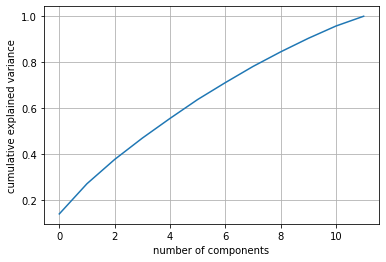

In [106]:
#to choose the correct number of components I plot cumulative explained variance ratio as a function of the number of components.

pca = PCA().fit(x)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.grid(True)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

#probabilmente sceglierò il 9 perchè copre quasi tutta la  varianza (circa 90%)

pca = PCA(n_components=9)
principalComponents = pca.fit_transform(x)#
feature_names=['1', '2','3','4','5','6','7','8','9']
principalDf = pd.DataFrame(data = principalComponents, columns = feature_names)

finalDf = pd.concat([principalDf, df[['DEATH_EVENT']]], axis = 1)

principalComponents
finalDf


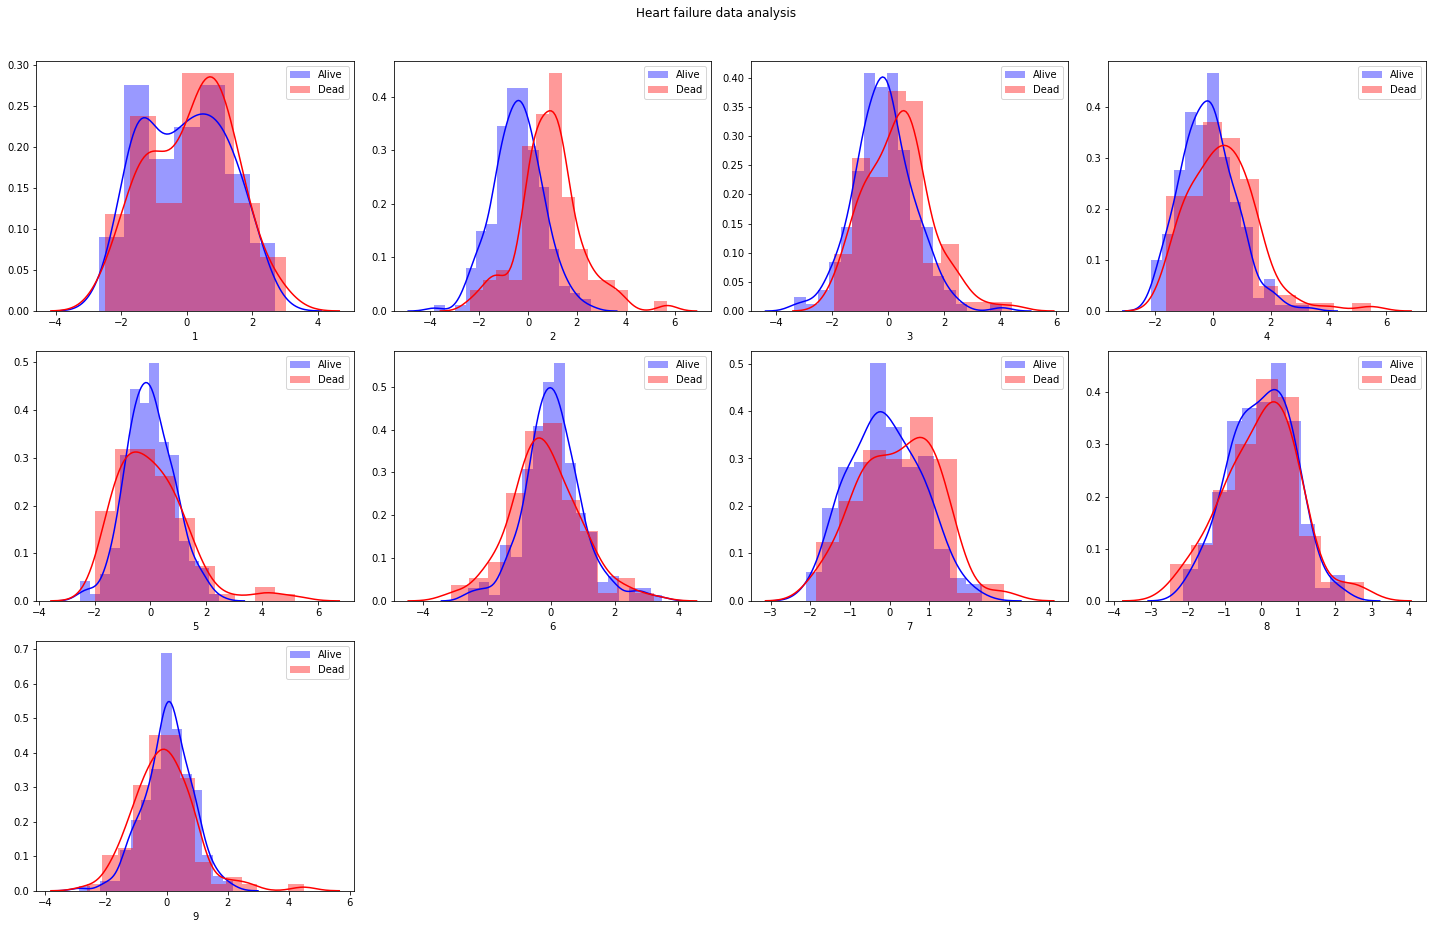

In [107]:
#Visualizing the selected features

fig = plt.figure(figsize = (20, 25))
j = 0
for i in principalDf.columns:
    plt.subplot(6, 4, j+1)
    j += 1
    sns.distplot(principalDf[i][df['DEATH_EVENT']==0], color='b', label = 'Alive')
    sns.distplot(principalDf[i][df['DEATH_EVENT']==1], color='r', label = 'Dead')
    plt.legend(loc='best')
fig.suptitle('Heart failure data analysis')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

#Linear SVM with K-fold cross validation using principal components

##Preparing dataset with principal components
I first divide the dataset into training set (80%) and test set(20%)





In [108]:
x_train, x_test, y_train, y_test = train_test_split(principalComponents, y, test_size = 0.2)

x_train_Df = pd.DataFrame(data = x_train, columns = feature_names)
y_train_Df =pd.DataFrame(data=y_train, columns= ["DEATH_EVENT"])


trainDf = pd.concat([x_train_Df, y_train_Df], axis = 1)
#x_val, x_test, y_val, y_test = train_test_split(x, y, test_size = 0.5)




##Model training, validation and testing
Since data is a bit unbalanced and in order to reduce overfitting I decided to apply the k-fold cross validation tecnique on 10 folds and apply linear svm

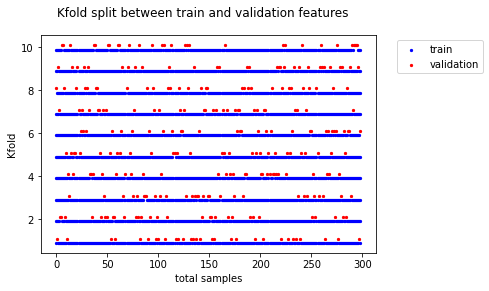

In [109]:
rn = range(0,299)
kf10 = KFold(n_splits=10, shuffle=True)

def kfoldize(kf, rn, shift=.1):
    train = pd.DataFrame()
    test = pd.DataFrame()
    i = 1
    for train_index, test_index in kf.split(rn):
        train_df = pd.DataFrame(np.take(rn, train_index), columns=["x"])
        train_df["val"] = i - shift
        train = train.append(train_df)

        test_df = pd.DataFrame(np.take(rn, test_index), columns=["x"])
        test_df["val"] = i + shift
        test = test.append(test_df)
        i += 1
    return train, test


train10, test10 = kfoldize(kf10,rn)


plt.scatter(x="x",y="val",c="b",label="train",s=5,data=train10)
plt.scatter(x="x",y="val",c="r",label="validation",s=5,data=test10)
plt.ylabel("Kfold")
plt.xlabel("total samples")
plt.suptitle("Kfold split between train and validation features")
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

In [110]:

C_best=0
acc_best=0

for C in [0.001, 0.01, 0.1, 1, 10, 100,1000]:
  
  print("analyzing C={}".format(C))
  
  fold = 0
  acc_array_SVM=[0,0,0,0,0,0,0,0,0,0]
  for train_index, test_index in kf10.split(trainDf):
      X_train = trainDf.iloc[train_index].loc[:, feature_names]
      X_val = trainDf.iloc[test_index][feature_names]
      y_train = trainDf.iloc[train_index].loc[:,'DEATH_EVENT']
      y_val = trainDf.loc[test_index]['DEATH_EVENT']

      #linear svm application 
      
      

      #print("Analyzing fold {} ...".format(fold))

    
      #train the data on the training set
      clf=svm.SVC(kernel='linear', C=C)
      clf.fit(X_train,y_train) #fit is used to train your pattern with some training data
    
      #evaluate the method on the validation set 
   
      y_p_SVM=clf.predict(X_val)
      acc_array_SVM[fold]= accuracy_score(y_val,y_p_SVM)
      fold=fold+1
    
  #get the mean of the accuracies for each fold
  print("total accuracy of the model after Cross Validation is:",mean(acc_array_SVM) * 100)
  

  #searching for the best hyperparameter in the fold
  if (mean(acc_array_SVM)>acc_best):
    C_best=C
    acc_best=mean(acc_array_SVM)
    bestModel=clf


print("\n")
print("Best hyperparameter for the model is C={}".format(C_best)) 

#Testing the model on the test set with the best hyperparameters
print("Testing the model on the test set with the best hyperparameter")
y_onTest_SVM=bestModel.predict(x_test)

acc_on_Test= accuracy_score(y_test,y_onTest_SVM)
print("Accuracy on test set={}".format(acc_on_Test))
  


analyzing C=0.001
total accuracy of the model after Cross Validation is: 70.30797101449274
analyzing C=0.01
total accuracy of the model after Cross Validation is: 72.40942028985506
analyzing C=0.1
total accuracy of the model after Cross Validation is: 79.49275362318839
analyzing C=1
total accuracy of the model after Cross Validation is: 81.1050724637681
analyzing C=10
total accuracy of the model after Cross Validation is: 80.30797101449275
analyzing C=100
total accuracy of the model after Cross Validation is: 82.40942028985508
analyzing C=1000
total accuracy of the model after Cross Validation is: 80.3623188405797


Best hyperparameter for the model is C=100
Testing the model on the test set with the best hyperparameter
Accuracy on test set=0.8


#Linear SVM  using all features and k-fold cross validation


##Preparing dataset without principal components
I divide the dataset into training set (80%) and test set (20%)

In [111]:
x_train_noPca, x_test_noPca, y_train_noPca, y_test_noPca = train_test_split(x, y, test_size = 0.2)

x_train_Df = pd.DataFrame(data = x_train_noPca, columns = features)
y_train_Df =pd.DataFrame(data=y_train_noPca, columns= ["DEATH_EVENT"])


trainDf = pd.concat([x_train_Df, y_train_Df], axis = 1)
#x_val, x_test, y_val, y_test = train_test_split(x, y, test_size = 0.5)


##Model training, validation and testing

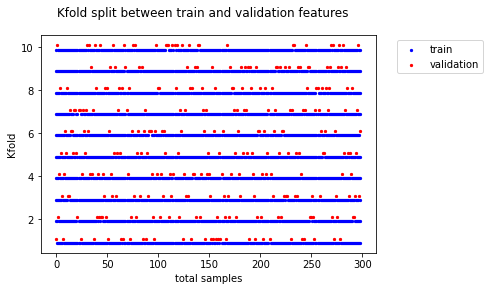

In [112]:
rn = range(0,299)
kf10 = KFold(n_splits=10, shuffle=True)

def kfoldize2(kf, rn, shift=.1):
    train = pd.DataFrame()
    test = pd.DataFrame()
    i = 1
    for train_index, test_index in kf.split(rn):
        train_df = pd.DataFrame(np.take(rn, train_index), columns=["x"])
        train_df["val"] = i - shift
        train = train.append(train_df)

        test_df = pd.DataFrame(np.take(rn, test_index), columns=["x"])
        test_df["val"] = i + shift
        test = test.append(test_df)
        i += 1
    return train, test


train10, test10 = kfoldize2(kf10,rn)


plt.scatter(x="x",y="val",c="b",label="train",s=5,data=train10)
plt.scatter(x="x",y="val",c="r",label="validation",s=5,data=test10)
plt.ylabel("Kfold")
plt.xlabel("total samples")
plt.suptitle("Kfold split between train and validation features")
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

In [113]:
C_best=0
acc_best=0

for C in [0.001, 0.01, 0.1, 1, 10, 100,1000]:
  
  print("analyzing C={}".format(C))
  
  fold = 0
  acc_array_SVM=[0,0,0,0,0,0,0,0,0,0]
  for train_index, test_index in kf10.split(trainDf):
      X_train = trainDf.iloc[train_index].loc[:, features]
      X_val = trainDf.iloc[test_index][features]
      y_train = trainDf.iloc[train_index].loc[:,'DEATH_EVENT']
      y_val = trainDf.loc[test_index]['DEATH_EVENT']

      #linear svm application 
      
      

      #print("Analyzing fold {} ...".format(fold))

    
      #train the data on the training set
      clf=svm.SVC(kernel='linear', C=C)
      clf.fit(X_train,y_train) #fit is used to train your pattern with some training data
    
      #evaluate the method on the validation set 
   
      y_p_SVM=clf.predict(X_val)
      acc_array_SVM[fold]= accuracy_score(y_val,y_p_SVM)
      fold=fold+1
    
  #get the mean of the accuracies for each fold
  print("total accuracy of the model after Cross Validation is:",mean(acc_array_SVM) * 100)
  

  #searching for the best hyperparameter in the fold
  if (mean(acc_array_SVM)>acc_best):
    C_best=C
    acc_best=mean(acc_array_SVM)
    bestModel=clf


print("\n")
print("Best hyperparameter for the model is C={}".format(C_best)) 

#Testing the model on the test set with the best hyperparameters
print("Testing the model on the test set with the best hyperparameter")
y_onTest_SVM=bestModel.predict(x_test_noPca)

acc_on_Test= accuracy_score(y_test_noPca,y_onTest_SVM)
print("Accuracy on test set={}".format(acc_on_Test))
  


analyzing C=0.001
total accuracy of the model after Cross Validation is: 67.7355072463768
analyzing C=0.01
total accuracy of the model after Cross Validation is: 72.69927536231884
analyzing C=0.1
total accuracy of the model after Cross Validation is: 79.4927536231884
analyzing C=1
total accuracy of the model after Cross Validation is: 79.47463768115941
analyzing C=10
total accuracy of the model after Cross Validation is: 77.82608695652173
analyzing C=100
total accuracy of the model after Cross Validation is: 79.0217391304348
analyzing C=1000
total accuracy of the model after Cross Validation is: 79.43840579710145


Best hyperparameter for the model is C=0.1
Testing the model on the test set with the best hyperparameter
Accuracy on test set=0.9


#RBF Kernel SVM
In order to try to increase the overall accuracy I try to apply the kernel trick.

As before I apply it using cross validation to reduce overfitting

##Model training, validation and testing

In [114]:
rn = range(0,299)
kf10 = KFold(n_splits=10, shuffle=True)

def kfoldize2(kf, rn, shift=.1):
    train = pd.DataFrame()
    test = pd.DataFrame()
    i = 1
    for train_index, test_index in kf.split(rn):
        train_df = pd.DataFrame(np.take(rn, train_index), columns=["x"])
        train_df["val"] = i - shift
        train = train.append(train_df)

        test_df = pd.DataFrame(np.take(rn, test_index), columns=["x"])
        test_df["val"] = i + shift
        test = test.append(test_df)
        i += 1
    return train, test


train10, test10 = kfoldize2(kf10,rn)


In [115]:
C_best=0
acc_best=0

for C in [0.001, 0.01, 0.1, 1, 10, 100,1000]:
  
  print("analyzing C={}".format(C))
  
  fold = 0
  acc_array_SVM=[0,0,0,0,0,0,0,0,0,0]
  for train_index, test_index in kf10.split(trainDf):
      X_train = trainDf.iloc[train_index].loc[:, features]
      X_val = trainDf.iloc[test_index][features]
      y_train = trainDf.iloc[train_index].loc[:,'DEATH_EVENT']
      y_val = trainDf.loc[test_index]['DEATH_EVENT']

      #linear svm application 
      
      

      #print("Analyzing fold {} ...".format(fold))

    
      #train the data on the training set
      clf=svm.SVC(kernel='rbf', C=C)
      clf.fit(X_train,y_train) #fit is used to train your pattern with some training data
    
      #evaluate the method on the validation set 
   
      y_p_SVM=clf.predict(X_val)
      acc_array_SVM[fold]= accuracy_score(y_val,y_p_SVM)
      fold=fold+1
    
  #get the mean of the accuracies for each fold
  print("total accuracy of the model after Cross Validation is:",mean(acc_array_SVM) * 100)
  

  #searching for the best hyperparameter in the fold
  if (mean(acc_array_SVM)>acc_best):
    C_best=C
    acc_best=mean(acc_array_SVM)
    bestModel=clf


print("\n")
print("Best hyperparameter for the model is C={}".format(C_best)) 

#Testing the model on the test set with the best hyperparameters
print("Testing the model on the test set with the best hyperparameter")
y_onTest_SVM=bestModel.predict(x_test_noPca)

acc_on_Test= accuracy_score(y_test_noPca,y_onTest_SVM)
print("Accuracy on test set={}".format(acc_on_Test))

analyzing C=0.001
total accuracy of the model after Cross Validation is: 67.82608695652175
analyzing C=0.01
total accuracy of the model after Cross Validation is: 67.71739130434781
analyzing C=0.1
total accuracy of the model after Cross Validation is: 67.71739130434783
analyzing C=1
total accuracy of the model after Cross Validation is: 75.36231884057972
analyzing C=10
total accuracy of the model after Cross Validation is: 76.17753623188406
analyzing C=100
total accuracy of the model after Cross Validation is: 74.87318840579711
analyzing C=1000
total accuracy of the model after Cross Validation is: 75.30797101449276


Best hyperparameter for the model is C=10
Testing the model on the test set with the best hyperparameter
Accuracy on test set=0.7833333333333333


linear SVM model performs better

#Logistic regression

In [116]:

fold = 0
acc_array_LR=[0,0,0,0,0,0,0,0,0,0]
for train_index, test_index in kf10.split(trainDf):
      X_train = trainDf.iloc[train_index].loc[:, features]
      X_val = trainDf.iloc[test_index][features]
      y_train = trainDf.iloc[train_index].loc[:,'DEATH_EVENT']
      y_val = trainDf.loc[test_index]['DEATH_EVENT']


      clf = LogisticRegression(random_state=0).fit(X_train,y_train)
      y_p_LR=clf.predict(X_val)
      acc_array_LR[fold]= accuracy_score(y_val,y_p_LR)
      fold=fold+1
#get the mean of the accuracies for each fold
print("total accuracy of the model after Cross Validation is:",mean(acc_array_LR) * 100)      

y_onTest_LR=clf.predict(x_test_noPca)

acc_on_Test= accuracy_score(y_test_noPca,y_onTest_LR)
print("Accuracy on test set={}".format(acc_on_Test))


total accuracy of the model after Cross Validation is: 80.32608695652173
Accuracy on test set=0.9


#Random forest

In [118]:

fold = 0
acc_array_RF=[0,0,0,0,0,0,0,0,0,0]
for train_index, test_index in kf10.split(trainDf):
      X_train = trainDf.iloc[train_index].loc[:, features]
      X_val = trainDf.iloc[test_index][features]
      y_train = trainDf.iloc[train_index].loc[:,'DEATH_EVENT']
      y_val = trainDf.loc[test_index]['DEATH_EVENT']


      clf = RandomForestClassifier(max_depth=10, random_state=0).fit(X_train,y_train)
      y_p_RF=clf.predict(X_val)

      
      acc_array_RF[fold]= accuracy_score(y_val,y_p_RF)
      fold=fold+1
#get the mean of the accuracies for each fold
print("total accuracy of the model after Cross Validation is:",mean(acc_array_RF) * 100)      

y_onTest_RF=clf.predict(x_test_noPca)

acc_on_Test= accuracy_score(y_test_noPca,y_onTest_RF)
print("Accuracy on test set={}".format(acc_on_Test))


total accuracy of the model after Cross Validation is: 83.71376811594203
Accuracy on test set=0.9
